##  <font color=MediumSlateBlue>Importing Libraries</font> ##

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import string
from sklearn.model_selection import train_test_split as trainTestSplitter

####  <font color=SlateBlue>Google Colab</font>

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')

####  <font color=SlateBlue>Preprocessing</font>

In [ ]:
#Tokenizing 
import nltk
nltk.download('punkt')

import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
# from torchtext.legacy.data import Field, TabularDataset
from torchtext.data import Field, TabularDataset

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


####  <font color=SlateBlue>Reading .txt File</font>

In [ ]:
import re

####  <font color=SlateBlue>CNN</font> ####

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

####  <font color=SlateBlue>Model Evaluation</font> ####

In [ ]:
from sklearn.metrics import accuracy_score as calcAccScore
from sklearn.metrics import classification_report as reportClassificationResults

##  <font color=MediumSlateBlue>Reading Data and Saving .csv File</font> ##

####  <font color=SlateBlue>Read and save to csv class where the given file is read, the extra not needed parts are excluded and the remaining desirable sentences and their corresponding lable are kept in a csv file.</font> ####

In [ ]:
class ReadAndSaveCSV():
  def __init__(self, filePath):
    self.filePath = filePath

  def readEachLine(self):
    self.fileLines = []
    with open(self.filePath, 'r') as file:
      allLines = file.readlines()
      self.fileLines += [line.strip() for line in allLines if not line=='\n']

  def removeComment(self):
    for line in self.fileLines:
      commentLine = re.search(r"\AComment", line)
      if not commentLine==None:
        self.fileLines.remove(line)
      else:
        continue
  
  def splitLines(self):
    temp = []

    for line in self.fileLines:
      temp.append(line.split('|'))

    self.fileLines = temp

  def separateRelationAndSentence(self):
    self.relations = []
    self.sentences = []

    for lineNum, lineContent in enumerate(self.fileLines,1):
      if (lineNum%2==0):
        self.relations.append(lineContent)
      else:
        self.sentences.append(lineContent)
  
  def setClassIndex(self):
    refDict = {'Cause-Effect':0, 
               'Instrument-Agency':1,
               'Product-Producer':2, 
               'Content-Container':3,
               'Entity-Origin':4, 
               'Entity-Destination':5,
               'Component-Whole':6, 
               'Member-Collection':7,
               'Message-Topic':8, 
               'Other':9
               }
    
    h = np.array(self.relations).shape
    indxRelations = np.zeros((h), dtype=np.int32)

    for key in refDict:
      idx = (np.array(self.relations)==np.array(key))
      validx = (idx==True) 
      indxRelations[validx] = np.array(refDict[key], dtype=np.int32)

    self.relations = indxRelations.tolist()

  def fixRelations(self, desiredLen=None):
    if not desiredLen==None:
      self.relations = self.relations[0:desiredLen]

    temp = ','.join(str(word) for relation in self.relations for word in relation)
    self.relations = re.sub(r'\([^)]*\)', "",temp).split(',')

    self.setClassIndex()
  
  def fixSentences(self, desiredLen=None):
    if not desiredLen==None:
      self.sentences = self.sentences[0:desiredLen]

    temp = []

    for sentence in self.sentences:
      sentence = ''.join(sentence)
      sentence = re.sub('\t','',sentence)
      sentence = sentence.lstrip('0123456789.-')
      sentence = re.sub('<[^>]*>', '', sentence)
      sentence = sentence.replace('"', '')
      temp.append(sentence)

    self.sentences = temp

  def toCSV(self, fileLoc, entityLoc=None):
    if entityLoc==None:
      allData = zip(self.sentences, self.relations)
      df = pd.DataFrame(allData, columns=['Sentences', 'Relations'])

    for punc in string.punctuation:
      df['Sentences'] = df.Sentences.str.replace(punc, " ")

    df.to_csv(fileLoc, index=False)  

  
  def performReadAndSave(self, fileLoc, desiredLen=None):
    self.readEachLine()
    self.removeComment()
    self.splitLines()
    self.separateRelationAndSentence()
    self.fixRelations(desiredLen)
    self.fixSentences(desiredLen)
    self.toCSV(fileLoc)


####  <font color=SlateBlue>Reading train file and altering it in the required manner. </font> ####

In [ ]:
TrainFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/TRAIN_FILE.TXT'

myFileSaver = ReadAndSaveCSV(TrainFilePath)
myFileSaver.performReadAndSave('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv', 7109)

####  <font color=SlateBlue>Reading test file and altering it in the required manner. </font> ####

In [ ]:
TestFilePath = '/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/TEST_FILE.TXT'

myFileSaver = ReadAndSaveCSV(TestFilePath)
myFileSaver.performReadAndSave('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Test_File.csv')

##  <font color=MediumSlateBlue>Split Train and Validation Datasets</font> ##

####  <font color=SlateBlue>Splitting the train dataset into train and validation datasets. About 20% of train dataset is introduced as validation dataset. </font> ####

In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv')
trainDF, validDF = trainTestSplitter(df, test_size=0.2, random_state=42)
trainDF.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv', index=False)
validDF.to_csv('/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Validation_File.csv', index=False)

##  <font color=MediumSlateBlue>Building Vocabulary</font> ##

####  <font color=SlateBlue>Vocabulary class which calculates the tokenized represetation of sentences</font> ####

In [ ]:
class Vocabulary():
  def __init__(self, minFreq):
    self.minFreq = minFreq

    self.vocabs = Field(sequential=True, 
                        use_vocab=True, 
                        init_token = '<sos>', 
                        eos_token = '<eos>',
                        tokenize=self.tokenizer, 
                        lower=True)

  def __len__(self): return len(self.vocabs.vocab.stoi)

  def tokenizer(self, text): return nltk.word_tokenize(text)

  def buildVocabulary(self, dataPath, format):
    fields = {'Sentences': ('s', self.vocabs)}
    dataset = TabularDataset(path=dataPath, format=format, 
                             fields=fields)
    
    self.vocabs.build_vocab(dataset, max_size=10000, min_freq=self.minFreq, vectors='glove.42B.300d')

  def numericalize(self, text):
    tokenizedText = self.tokenizer(text)

    return [
        self.vocabs.vocab.stoi[token] 
        if token in self.vocabs.vocab.stoi 
        else self.vocabs.vocab.stoi['<unk>']
        for token in tokenizedText
        ]

####  <font color=SlateBlue>MyCollate is a class responsible for padding. </font> ####

In [ ]:
class MyCollate():
  def __init__(self, padIndx):
    self.padIndx = padIndx

  def __call__(self, batch):
    relations = torch.cat([item[1] for item in batch], dim=0)

    sentences = [item[0] for item in batch]
    sentences = pad_sequence(sentences, 
                           batch_first=False, 
                           padding_value=self.padIndx)

    return sentences, relations

####  <font color=SlateBlue>SemEvalTaskDataset is a class which reads all sentences and their corresponding relation.</font> ####

In [ ]:
class SemEvalTaskDataset(Dataset):
  def __init__(self, fileLoc, sentenceVocab, mode='Train'):
    
    self.df = pd.read_csv(fileLoc)

    self.sentences = self.df['Sentences']
    self.relations = self.df['Relations']

    self.sentenceVocab = sentenceVocab

    if mode == 'Train':
      self.sentenceVocab.buildVocabulary(
          dataPath=fileLoc, 
          format='csv'
          )

  def __len__(self): return len(self.df)

  def getBuiltVocab(self): return self.sentenceVocab

  def __getitem__(self, indx):
    relation = self.relations[indx]

    sentence = self.sentences[indx]
    numericalizedSentence = [self.sentenceVocab.vocabs.vocab.stoi['<sos>']]
    numericalizedSentence.extend(self.sentenceVocab.numericalize(sentence))
    numericalizedSentence.append(self.sentenceVocab.vocabs.vocab.stoi['<eos>'])
  
    return torch.tensor(numericalizedSentence), torch.tensor([relation])

####  <font color=SlateBlue>Getloader is a function returning a dataloader as well as the created dataset based on the given data</font> ####

In [ ]:
def getLoader(fileLoc, 
              sentenceVocab,  
              mode, 
              batchSize=256, 
              numWorkers=0, 
              shuffle=True, 
              pinMemory=True):
  
  dataset = SemEvalTaskDataset(fileLoc, sentenceVocab, mode)

  padIndx = (dataset.getBuiltVocab()).vocabs.vocab.stoi['<pad>']

  loader = DataLoader(dataset=dataset,
                      batch_size=batchSize,
                      num_workers=numWorkers,
                      shuffle=shuffle,
                      pin_memory=pinMemory,
                      collate_fn=MyCollate(padIndx=padIndx))

  return loader, dataset

####  <font color=SlateBlue>Creating train dataloader and dataset.</font> ####

In [ ]:
trainDataLoader, trainDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Train_File.csv',
    fileLoc='../input/my-semeval2010-task-8/Train_File.csv',
    sentenceVocab=Vocabulary(5),
    mode='Train',
    batchSize=8,
    numWorkers=2)

/opt/conda/lib/python3.7/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:68: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/opt/conda/lib/python3.7/site-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warn

####  <font color=SlateBlue>Creating validation dataloader and dataset.</font> ####

In [ ]:
validDataLoader, validDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Validation_File.csv',
    fileLoc='../input/my-semeval2010-task-8/Validation_File.csv',
    sentenceVocab=trainDataset.getBuiltVocab(),
    mode='Valid',
    batchSize=8,
    numWorkers=2)

####  <font color=SlateBlue>Creating test dataloader and dataset.</font> ####

In [ ]:
testDataLoader, testDataset = getLoader(
#     fileLoc='/content/gdrive/MyDrive/Colab Notebooks/Deep Learning/HW/3/Test_File.csv',
    fileLoc='../input/my-semeval2010-task-8/Test_File.csv',
    sentenceVocab=trainDataset.getBuiltVocab(),
    mode='Test',
    batchSize=1,
    numWorkers=2)

##  <font color=MediumSlateBlue>Creating the Neural Network.</font> ##

In [ ]:
class RENeuralNetwork(nn.Module):
  def __init__(self,
               embeddingVectors,
               vocabSize, 
               embedSize=300,
               hiddenSize=150,
               numLayers=2, 
               LSTMDropout=0, 
               dropoutP=0.7,
               numClass=10):
    super(RENeuralNetwork, self).__init__()
    
    self.embed = nn.Embedding(num_embeddings=vocabSize, 
                              embedding_dim=embedSize)
    self.embed.weight.data.copy_(embeddingVectors)
    self.embed.weight.requires_grad = False
    
    self.lstm = nn.LSTM(input_size=embedSize, 
                        hidden_size=hiddenSize, 
                        num_layers=numLayers,
                        dropout=LSTMDropout,
                        bidirectional=True)
    
    self.linear = nn.Linear(in_features=2*hiddenSize, 
                            out_features=numClass)
    
    self.dropout = nn.Dropout(p=dropoutP)

    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, inputSentence, concatIndexes=[-2, -1]):
    embedSentence =  self.dropout(self.embed(inputSentence))
    output, (h_n, c_n) = self.lstm(embedSentence)
    output = torch.cat((h_n[concatIndexes[0], :, :], 
                        h_n[concatIndexes[1], :, :]), 
                       dim=1
                       )
    output = self.linear(output)
    return self.softmax(output)

##  <font color=MediumSlateBlue>Training the Neural Network.</font> #

In [ ]:
def train(trainDataLoader, trainDataset,
          validDataLoader, testDataLoader,
          embedSize=300, hiddenSize=150,
          numLayers=2, LSTMDropout=0.5,
          dropoutP=0.7, numEpochs=30,
          freezeState=True):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  datasetVocab = (trainDataset.getBuiltVocab()).vocabs.vocab

  #Hyperparameters
  vocabSize = len(datasetVocab)
  learningRate = 3e-4

  #Model creation
  model = RENeuralNetwork(embeddingVectors=datasetVocab.vectors,
                          vocabSize=vocabSize,
                          embedSize=embedSize,
                          hiddenSize=hiddenSize,
                          numLayers=numLayers,
                          LSTMDropout=LSTMDropout,
                          dropoutP=dropoutP,
                          numClass=10).to(device)

  criterion = nn.NLLLoss(ignore_index=datasetVocab.stoi['<pad>'])
  optimizer = optim.Adam(model.parameters(), lr=learningRate)

  allEpochTrainLoss, allEpochValidLoss = [], []
  trainAcc, validAcc = [], []

  for numEpoch in range(numEpochs):
    print('Epoch %d has started......' %(numEpoch+1))
    oneEpochTrainLoss, oneEpochValidLoss = 0, 0
    oneEpochTrainAcc, oneEpochValidAcc = [], []

    print('Training the network......')
    model.train()

    for iteration, (sentences, labels) in enumerate(trainDataLoader):
      sentences = sentences.to(device)
      labels = labels.to(device)

      outputs = model(sentences)
      loss = criterion(outputs, labels)
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      oneEpochTrainLoss += loss.item()

      outputs = outputs.max(dim=1)[1]
      oneEpochTrainAcc.append(calcAccScore(labels.data.cpu().detach().numpy(), outputs.data.cpu().detach().numpy()))

      #Printing training loss every 70 iterations
      if (iteration+1)%70==0: 
        print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochTrainLoss/(iteration+1)))

    #Printing training loss and accuracy at the end of each epoch
    print('At the end of epoch %d:' %(numEpoch+1))
    print('The average training loss is: %1.5f' %(oneEpochTrainLoss/len(trainDataLoader)))
    print('The accuracy on training data is: %1.5f' %(sum(oneEpochTrainAcc)/len(oneEpochTrainAcc)))

    allEpochTrainLoss.append(oneEpochTrainLoss/len(trainDataLoader))
    trainAcc.append(sum(oneEpochTrainAcc)/len(oneEpochTrainAcc))

    #Plotting training loss and accuracy in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochTrainLoss, label='Training Loss', color='slateblue')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      plt.plot(trainAcc, label='Training Accuracy', color='slateblue')
      plt.title('Accuracy vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Accuracy')
      plt.legend(loc='best')
      plt.show()

    print('...............................................')
    print('Validating the network......')
    model.eval()

    with torch.no_grad():
      for iteration, (sentences, labels) in enumerate(validDataLoader):
        sentences = sentences.to(device)
        labels = labels.to(device)

        outputs = model(sentences)
        loss = criterion(outputs, labels)
  
        oneEpochValidLoss += loss.item()

        outputs = outputs.max(dim=1)[1]
        oneEpochValidAcc.append(calcAccScore(labels.data.cpu().detach().numpy(), outputs.data.cpu().detach().numpy()))

        #Printing validation loss every 20 iterations
        if (iteration+1)%20==0:
          print('Iteration:%d \t Loss:%1.5f' %(iteration+1, oneEpochValidLoss/(iteration+1)))

    #Printing validation loss and accuracy at the end of each epoch
    print('At the end of epoch %d:' %(numEpoch+1))
    print('The average validation loss is: %1.5f' %(oneEpochValidLoss/len(validDataLoader)))
    print('The accuracy on validation data is: %1.5f' %(sum(oneEpochValidAcc)/len(oneEpochValidAcc)))

    allEpochValidLoss.append(oneEpochValidLoss/len(validDataLoader))
    validAcc.append(sum(oneEpochValidAcc)/len(oneEpochValidAcc))

    #Plotting validation loss and accuracy in every 10 epochs
    if (numEpoch+1)%10==0:
      plt.plot(allEpochValidLoss, label='Validation Loss', color='mediumpurple')
      plt.title('Loss vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Loss')
      plt.legend(loc='best')
      plt.show()

      plt.plot(validAcc, label='Validation Accuracy', color='mediumpurple')
      plt.title('Accuracy vs. Epochs')
      plt.xlabel('Number of Epochs Untill Now')
      plt.ylabel('Accuracy')
      plt.legend(loc='best')
      plt.show()      

    print('********************************************************')

  plt.plot(allEpochTrainLoss, label='Training Loss', color='slateblue')
  plt.plot(allEpochValidLoss, label='Validation Loss', color='mediumpurple')
  plt.title('Loss vs. Epochs')
  plt.xlabel('Number of Epochs')
  plt.ylabel('Loss')
  plt.legend(loc='best')
  plt.show() 

  plt.plot(trainAcc, label='Training Accuracy', color='slateblue')
  plt.plot(validAcc, label='Validation Accuracy', color='mediumpurple')
  plt.title('Accuracy vs. Epochs')
  plt.xlabel('Number of Epochs Untill Now')
  plt.ylabel('Accuracy')
  plt.legend(loc='best')
  plt.show() 

  with torch.no_grad():
    allLabels, allOutputs = [], []
    for sentences, labels in testDataLoader:
      sentences = sentences.to(device)
      outputs = model(sentences)
      outputs = outputs.max(dim=1)[1]

      allLabels.append(labels.data.cpu().numpy())
      allOutputs.append(outputs.data.cpu().numpy())



  print(reportClassificationResults(allLabels, allOutputs, zero_division=0))

Epoch 1 has started......
Training the network......
Iteration:70 	 Loss:2.24437
Iteration:140 	 Loss:2.21011
Iteration:210 	 Loss:2.18460
Iteration:280 	 Loss:2.13791
Iteration:350 	 Loss:2.08584
Iteration:420 	 Loss:2.03523
Iteration:490 	 Loss:2.00123
Iteration:560 	 Loss:1.95830
Iteration:630 	 Loss:1.91618
Iteration:700 	 Loss:1.88574
At the end of epoch 1:
The average training loss is: 1.88241
The accuracy on training data is: 0.28067
...............................................
Validating the network......
Iteration:20 	 Loss:1.41035
Iteration:40 	 Loss:1.51883
Iteration:60 	 Loss:1.48240
Iteration:80 	 Loss:1.50162
Iteration:100 	 Loss:1.49060
Iteration:120 	 Loss:1.48881
Iteration:140 	 Loss:1.48340
Iteration:160 	 Loss:1.46666
At the end of epoch 1:
The average validation loss is: 1.46853
The accuracy on validation data is: 0.43001
********************************************************
Epoch 2 has started......
Training the network......
Iteration:70 	 Loss:1.49166
Itera

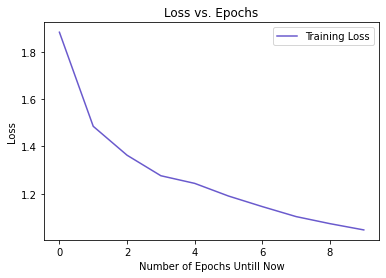

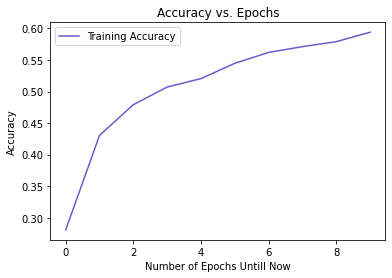

...............................................
Validating the network......
Iteration:20 	 Loss:0.94809
Iteration:40 	 Loss:1.07233
Iteration:60 	 Loss:1.03472
Iteration:80 	 Loss:1.03593
Iteration:100 	 Loss:1.03879
Iteration:120 	 Loss:1.02651
Iteration:140 	 Loss:0.99525
Iteration:160 	 Loss:1.00017
At the end of epoch 10:
The average validation loss is: 1.00650
The accuracy on validation data is: 0.59340


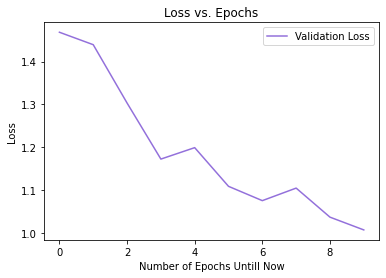

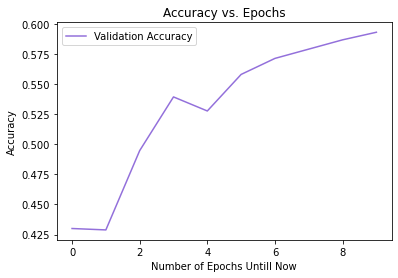

********************************************************
Epoch 11 has started......
Training the network......
Iteration:70 	 Loss:1.02607
Iteration:140 	 Loss:0.97049
Iteration:210 	 Loss:0.98125
Iteration:280 	 Loss:0.98057
Iteration:350 	 Loss:0.99010
Iteration:420 	 Loss:0.99274
Iteration:490 	 Loss:1.00849
Iteration:560 	 Loss:1.02045
Iteration:630 	 Loss:1.02153
Iteration:700 	 Loss:1.02129
At the end of epoch 11:
The average training loss is: 1.01791
The accuracy on training data is: 0.60245
...............................................
Validating the network......
Iteration:20 	 Loss:0.90503
Iteration:40 	 Loss:0.97889
Iteration:60 	 Loss:1.00379
Iteration:80 	 Loss:1.04971
Iteration:100 	 Loss:1.01704
Iteration:120 	 Loss:1.00498
Iteration:140 	 Loss:0.99424
Iteration:160 	 Loss:0.98024
At the end of epoch 11:
The average validation loss is: 0.97840
The accuracy on validation data is: 0.60744
********************************************************
Epoch 12 has started......

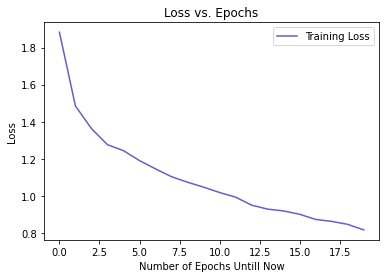

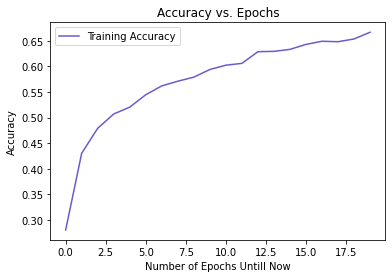

...............................................
Validating the network......
Iteration:20 	 Loss:1.00848
Iteration:40 	 Loss:1.02898
Iteration:60 	 Loss:0.96087
Iteration:80 	 Loss:0.96133
Iteration:100 	 Loss:0.97180
Iteration:120 	 Loss:0.93473
Iteration:140 	 Loss:0.95021
Iteration:160 	 Loss:0.96291
At the end of epoch 20:
The average validation loss is: 0.95186
The accuracy on validation data is: 0.61728


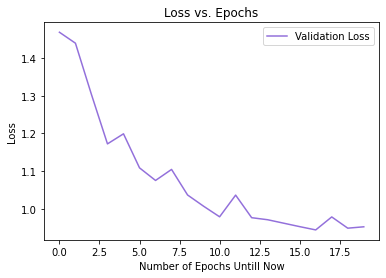

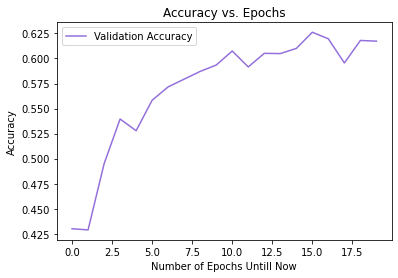

********************************************************
Epoch 21 has started......
Training the network......
Iteration:70 	 Loss:0.82414
Iteration:140 	 Loss:0.80197
Iteration:210 	 Loss:0.79463
Iteration:280 	 Loss:0.80820
Iteration:350 	 Loss:0.80854
Iteration:420 	 Loss:0.80421
Iteration:490 	 Loss:0.80396
Iteration:560 	 Loss:0.79698
Iteration:630 	 Loss:0.78883
Iteration:700 	 Loss:0.78703
At the end of epoch 21:
The average training loss is: 0.78484
The accuracy on training data is: 0.67877
...............................................
Validating the network......
Iteration:20 	 Loss:0.91974
Iteration:40 	 Loss:0.89718
Iteration:60 	 Loss:0.89845
Iteration:80 	 Loss:0.89993
Iteration:100 	 Loss:0.91755
Iteration:120 	 Loss:0.93849
Iteration:140 	 Loss:0.94768
Iteration:160 	 Loss:0.96385
At the end of epoch 21:
The average validation loss is: 0.96205
The accuracy on validation data is: 0.61236
********************************************************
Epoch 22 has started......

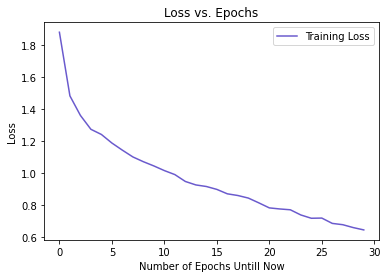

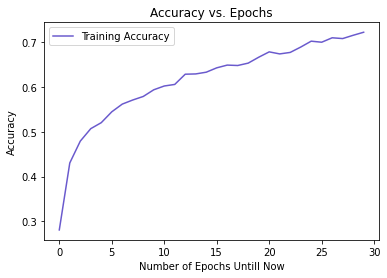

...............................................
Validating the network......
Iteration:20 	 Loss:1.09710
Iteration:40 	 Loss:1.02975
Iteration:60 	 Loss:0.99177
Iteration:80 	 Loss:0.98164
Iteration:100 	 Loss:1.01280
Iteration:120 	 Loss:1.02466
Iteration:140 	 Loss:0.98671
Iteration:160 	 Loss:0.97042
At the end of epoch 30:
The average validation loss is: 0.95958
The accuracy on validation data is: 0.62781


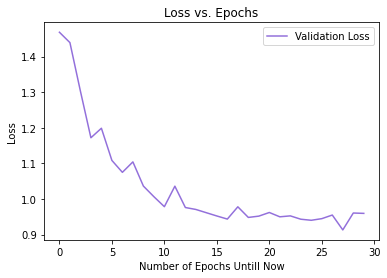

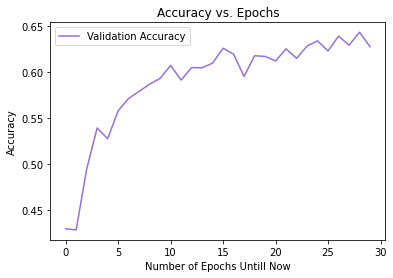

********************************************************
Epoch 31 has started......
Training the network......
Iteration:70 	 Loss:0.63598
Iteration:140 	 Loss:0.62932
Iteration:210 	 Loss:0.62663
Iteration:280 	 Loss:0.62780
Iteration:350 	 Loss:0.62506
Iteration:420 	 Loss:0.63886
Iteration:490 	 Loss:0.63367
Iteration:560 	 Loss:0.62907
Iteration:630 	 Loss:0.63366
Iteration:700 	 Loss:0.62459
At the end of epoch 31:
The average training loss is: 0.62334
The accuracy on training data is: 0.72993
...............................................
Validating the network......
Iteration:20 	 Loss:0.97208
Iteration:40 	 Loss:1.00375
Iteration:60 	 Loss:1.04779
Iteration:80 	 Loss:1.04263
Iteration:100 	 Loss:1.03292
Iteration:120 	 Loss:1.00988
Iteration:140 	 Loss:1.00733
Iteration:160 	 Loss:0.99667
At the end of epoch 31:
The average validation loss is: 1.00002
The accuracy on validation data is: 0.63179
********************************************************
Epoch 32 has started......

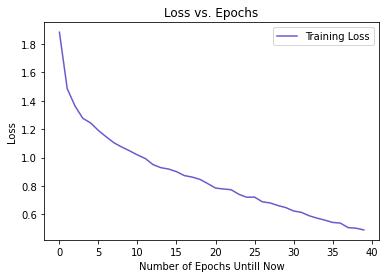

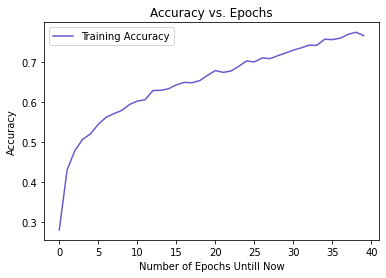

...............................................
Validating the network......
Iteration:20 	 Loss:0.91167
Iteration:40 	 Loss:1.03764
Iteration:60 	 Loss:1.01656
Iteration:80 	 Loss:1.03967
Iteration:100 	 Loss:1.06584
Iteration:120 	 Loss:1.03140
Iteration:140 	 Loss:0.99876
Iteration:160 	 Loss:1.01958
At the end of epoch 40:
The average validation loss is: 1.03090
The accuracy on validation data is: 0.64419


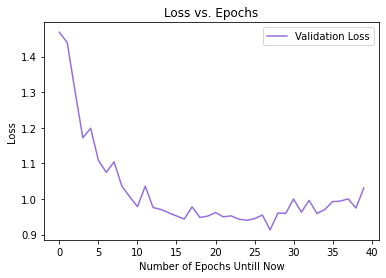

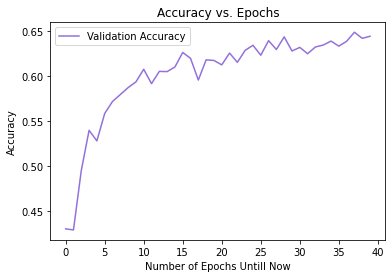

********************************************************
Epoch 41 has started......
Training the network......
Iteration:70 	 Loss:0.46009
Iteration:140 	 Loss:0.46453
Iteration:210 	 Loss:0.47855
Iteration:280 	 Loss:0.47332
Iteration:350 	 Loss:0.47189
Iteration:420 	 Loss:0.47886
Iteration:490 	 Loss:0.48014
Iteration:560 	 Loss:0.47141
Iteration:630 	 Loss:0.47585
Iteration:700 	 Loss:0.47810
At the end of epoch 41:
The average training loss is: 0.48130
The accuracy on training data is: 0.77627
...............................................
Validating the network......
Iteration:20 	 Loss:1.10974
Iteration:40 	 Loss:1.01968
Iteration:60 	 Loss:1.01710
Iteration:80 	 Loss:0.98575
Iteration:100 	 Loss:0.97675
Iteration:120 	 Loss:0.97045
Iteration:140 	 Loss:0.98642
Iteration:160 	 Loss:0.99244
At the end of epoch 41:
The average validation loss is: 0.99542
The accuracy on validation data is: 0.64162
********************************************************
Epoch 42 has started......

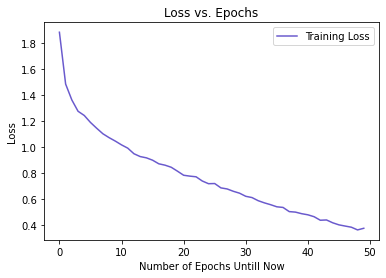

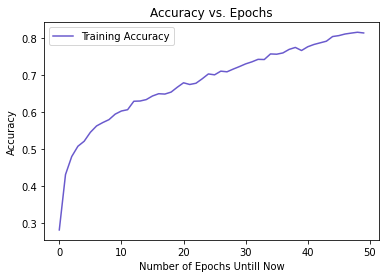

...............................................
Validating the network......
Iteration:20 	 Loss:1.17510
Iteration:40 	 Loss:1.13595
Iteration:60 	 Loss:1.12373
Iteration:80 	 Loss:1.09271
Iteration:100 	 Loss:1.08355
Iteration:120 	 Loss:1.13005
Iteration:140 	 Loss:1.08009
Iteration:160 	 Loss:1.07734
At the end of epoch 50:
The average validation loss is: 1.07884
The accuracy on validation data is: 0.65169


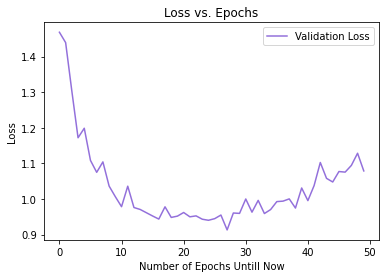

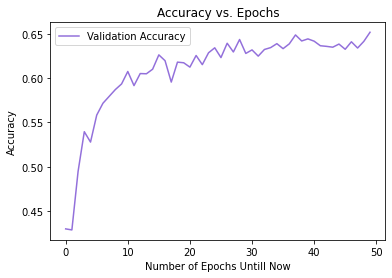

********************************************************
Epoch 51 has started......
Training the network......
Iteration:70 	 Loss:0.34518
Iteration:140 	 Loss:0.35876
Iteration:210 	 Loss:0.34247
Iteration:280 	 Loss:0.35688
Iteration:350 	 Loss:0.34886
Iteration:420 	 Loss:0.33913
Iteration:490 	 Loss:0.34089
Iteration:560 	 Loss:0.34413
Iteration:630 	 Loss:0.34853
Iteration:700 	 Loss:0.34772
At the end of epoch 51:
The average training loss is: 0.34963
The accuracy on training data is: 0.82587
...............................................
Validating the network......
Iteration:20 	 Loss:1.01645
Iteration:40 	 Loss:1.09802
Iteration:60 	 Loss:1.09515
Iteration:80 	 Loss:1.14013
Iteration:100 	 Loss:1.12122
Iteration:120 	 Loss:1.11681
Iteration:140 	 Loss:1.10345
Iteration:160 	 Loss:1.12401
At the end of epoch 51:
The average validation loss is: 1.12820
The accuracy on validation data is: 0.63881
********************************************************
Epoch 52 has started......

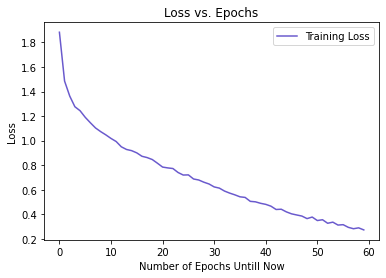

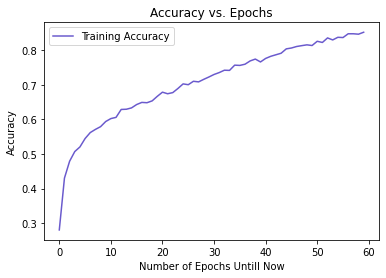

...............................................
Validating the network......
Iteration:20 	 Loss:1.25309
Iteration:40 	 Loss:1.29844
Iteration:60 	 Loss:1.25945
Iteration:80 	 Loss:1.30051
Iteration:100 	 Loss:1.27501
Iteration:120 	 Loss:1.28253
Iteration:140 	 Loss:1.26914
Iteration:160 	 Loss:1.22496
At the end of epoch 60:
The average validation loss is: 1.22308
The accuracy on validation data is: 0.63038


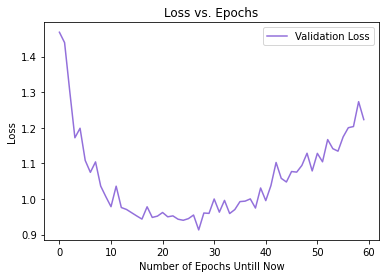

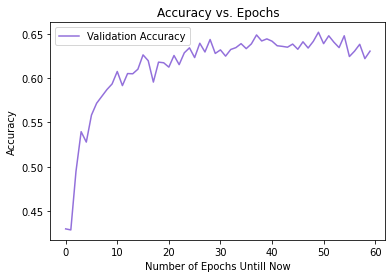

********************************************************
Epoch 61 has started......
Training the network......
Iteration:70 	 Loss:0.22786
Iteration:140 	 Loss:0.26295
Iteration:210 	 Loss:0.26446
Iteration:280 	 Loss:0.27085
Iteration:350 	 Loss:0.26845
Iteration:420 	 Loss:0.26662
Iteration:490 	 Loss:0.26745
Iteration:560 	 Loss:0.26909
Iteration:630 	 Loss:0.27249
Iteration:700 	 Loss:0.27336
At the end of epoch 61:
The average training loss is: 0.27283
The accuracy on training data is: 0.85142
...............................................
Validating the network......
Iteration:20 	 Loss:1.13611
Iteration:40 	 Loss:1.20361
Iteration:60 	 Loss:1.31038
Iteration:80 	 Loss:1.27762
Iteration:100 	 Loss:1.24421
Iteration:120 	 Loss:1.21708
Iteration:140 	 Loss:1.22070
Iteration:160 	 Loss:1.22330
At the end of epoch 61:
The average validation loss is: 1.23897
The accuracy on validation data is: 0.64139
********************************************************
Epoch 62 has started......

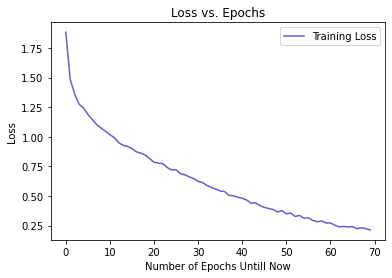

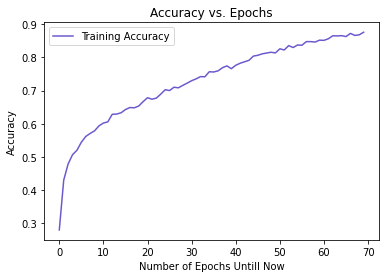

...............................................
Validating the network......
Iteration:20 	 Loss:1.16015
Iteration:40 	 Loss:1.06781
Iteration:60 	 Loss:1.16001
Iteration:80 	 Loss:1.18279
Iteration:100 	 Loss:1.25577
Iteration:120 	 Loss:1.30457
Iteration:140 	 Loss:1.37694
Iteration:160 	 Loss:1.38795
At the end of epoch 70:
The average validation loss is: 1.36042
The accuracy on validation data is: 0.63530


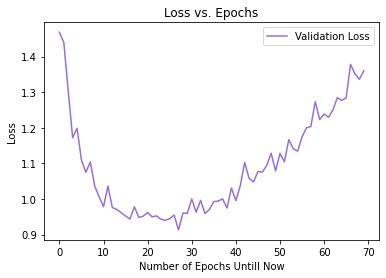

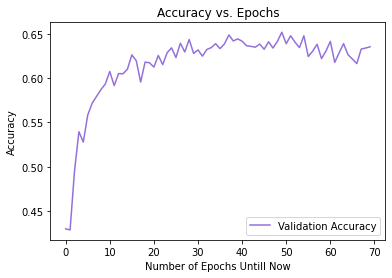

********************************************************


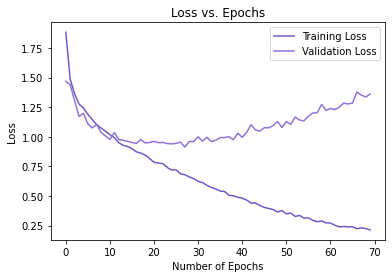

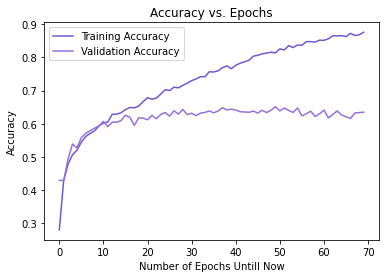

              precision    recall  f1-score   support

           0       0.75      0.87      0.80       328
           1       0.00      0.00      0.00       156
           2       0.45      0.56      0.50       231
           3       0.71      0.85      0.78       192
           4       0.72      0.66      0.69       258
           5       0.76      0.85      0.80       292
           6       0.61      0.67      0.64       312
           7       0.58      0.68      0.62       233
           8       0.65      0.70      0.68       261
           9       0.32      0.25      0.28       454

    accuracy                           0.61      2717
   macro avg       0.55      0.61      0.58      2717
weighted avg       0.56      0.61      0.58      2717



In [ ]:
train(trainDataLoader, trainDataset,
      validDataLoader, testDataLoader,
      numEpochs=70)